## **Mount drive** 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
cd /content/drive/MyDrive/ITU/ML/Assignment2

[WinError 3] The system cannot find the path specified: '/content/drive/MyDrive/ITU/ML/Assignment2'
D:\ITU\sem2\ML\assignmnets\2


## **Unzip Dataset**

In [19]:
import zipfile
with zipfile.ZipFile('CelebA.zip', 'r') as zip_ref:
    zip_ref.extractall('CelebA')

with zipfile.ZipFile('CelebA/CelebA/Img/img_align_celeba.zip', 'r') as zip_ref:
    zip_ref.extractall('/CelebA/CelebA/Img')

## **Import Libraries**

In [1]:
import pandas as pd 
import os
import cv2

import numpy as np
import torch
import torchvision
from torch import nn
from torchvision import transforms, datasets

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


## **Preparing Dataset for task 1**

**Data Preprocessing: Selecting 120 unique identities**

In [8]:
# specify paths 
label_file = '..\CelebA\Anno\identity_CelebA.txt'
img_dir = '..\CelebA\Img\img_align_celeba\img_align_celeba'
output_dir = '..\\task1_data'

# load labels file
data= pd.read_csv(label_file, sep=' ', header=None, names=['img', 'id'])

# mean_value of images for each label
mean_count = data['id'].value_counts().mean()

# selecting 120 unique entries having examples more than mean_count
selected_ids = [id for id,count in data['id'].value_counts().items() if count>mean_count][0:120]

# selecting images of selected_ids and creating a new dataset for this task


os.makedirs(output_dir, exist_ok=True)
for i in selected_ids: 
    os.makedirs(os.path.join(output_dir, str(i)), exist_ok=True)

for i in selected_ids:
    # find imgs belonging to class i
    id_df = data.loc[data.id == i]

    # create image list
    img_list = id_df.img.to_list()
  
    for img in img_list:
        # reading img
        image = cv2.imread(os.path.join(img_dir,img))

        # saving image in the relevant directory
        cv2.imwrite(os.path.join(output_dir,str(i),img), image)

**Data Loading: Spliting into test train and validation**

In [3]:
def load_dataset(dataset_path,train_size, validation_size, test_size, batch_size):

    transform = transforms.Compose([#transforms.Grayscale(), 
                                         transforms.ToTensor(),
                                         #transforms.Resize((28,28)), 
                                         transforms.Normalize([0,0,0],[0.5, 0.5, 0.5])
                                         ])
    # read dataset
    dataset = datasets.ImageFolder(dataset_path, transform=transform)

    # specify sizes
    train_set_size = int(len(dataset) * train_size)
    test_set_size = int(len(dataset) * test_size)
    val_set_size = len(dataset) - train_set_size - test_set_size

    # split data
    train_data, val_data, test_data = torch.utils.data.random_split(dataset, [train_set_size,val_set_size,test_set_size])

    # create dataloader for each data (test,train,val)
    train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_data_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)
    test_data_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
    #return test_data
    return train_data_loader, val_data_loader, test_data_loader

In [4]:
train_data_loader, val_data_loader, test_data_loader =  load_dataset('..\\task1_data',0.7,0.15,0.15, 16)

## **Creating Model**

In [5]:
from torch import nn
import torch.nn.functional as F
from torch import optim


## image size = 3x 218 x178
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn_layers = nn.Sequential(
            # Defining a 2D convolution layer
            nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_layers = nn.Sequential(
            nn.Linear(16 * 54 * 44, 120)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

# model
net = Net().to(device)

## Training Model

In [68]:
def train(epochs, train_data_loader, val_data_loader, loss_func, optimizer, learning_rate):
    optimizer1 = optimizer(net.parameters(), lr=learning_rate)
    train_step = len(train_data_loader)
    val_step = len(val_data_loader)
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []
    early_stoping_flag = 0
    learning_rate_decay_flag = 0
    EPS = 1e-2

    for epoch in range(epochs): # iterate over epochs
        if epoch >=2:
            if train_loss[-2] - train_loss[-1] <EPS:
                learning_rate_decay_flag+=1
            else:
                learning_rate_decay_flag =0
#             if val_loss[-1] - val_loss[-2] >EPS and train_loss[-2] - train_loss[-1] >EPS :
#                 early_stoping_flag+=1
#             else:
#                 early_stoping_flag =0
        
        if learning_rate_decay_flag >=3:
            learning_rate = learning_rate/10
            optimizer1 = optimizer(net.parameters(), lr=learning_rate)
            learning_rate_decay_flag =0
        
#         if early_stoping_flag >=3:
#             return train_loss, train_acc, val_loss, val_acc

        t_loss = 0
        t_acc = 0 
        for i, data in enumerate(train_data_loader): # iterate over batches
            # get image and labels data is in tuple form (inputs, label)
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero-out gradients
            optimizer1.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            _, pred = torch.max(outputs, 1)
            loss = loss_func(outputs, labels)
            loss.backward()
            optimizer1.step()
            t_loss += loss.item()
            t_acc += torch.sum(pred == labels)/len(labels)

            if (i+1) % 10 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' .format(epoch+1, epochs, i+1, train_step, loss.item()))
    
        v_loss = 0
        v_acc = 0
        for i, data in enumerate(val_data_loader): # iterate over batches
            # get image and labels data is in tuple form (inputs, label)
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = net(inputs)
            _, pred = torch.max(outputs, 1)
            loss = loss_func(outputs, labels)
            v_loss += loss.item()
            v_acc += torch.sum(pred == labels)/len(labels)
     
        train_loss.append(t_loss/train_step)
        train_acc.append(t_acc/train_step)
        val_loss.append(v_loss/val_step)
        val_acc.append(v_acc/val_step)
        print ('Epoch [{}/{}], train_loss: {:.4f}, val_loss: {:.4f}' .format(epoch+1, epochs, train_loss[-1], val_loss[-1]))
    return train_loss, train_acc, val_loss, val_acc

In [9]:
path = '../saved_models/task1/epoch10_0.001/task1.pt'
net = Net().to(device)
net.load_state_dict(torch.load(path))

<All keys matched successfully>

In [69]:
# loss
criterion = nn.CrossEntropyLoss()
epoch = 20

#optimizer
learning_rate = 0.0001
optimizer = optim.Adam

#training
train_loss, train_acc, val_loss, val_acc= train(epoch, train_data_loader,  val_data_loader,criterion, optimizer, learning_rate)

Epoch [1/20], Step [10/160], Loss: 0.6386
Epoch [1/20], Step [20/160], Loss: 0.6409
Epoch [1/20], Step [30/160], Loss: 0.2338
Epoch [1/20], Step [40/160], Loss: 0.4644
Epoch [1/20], Step [50/160], Loss: 0.1191
Epoch [1/20], Step [60/160], Loss: 0.1610
Epoch [1/20], Step [70/160], Loss: 0.2020
Epoch [1/20], Step [80/160], Loss: 0.2909
Epoch [1/20], Step [90/160], Loss: 0.1277
Epoch [1/20], Step [100/160], Loss: 0.2055
Epoch [1/20], Step [110/160], Loss: 0.1949
Epoch [1/20], Step [120/160], Loss: 0.1448
Epoch [1/20], Step [130/160], Loss: 0.1885
Epoch [1/20], Step [140/160], Loss: 0.3675
Epoch [1/20], Step [150/160], Loss: 0.3333
Epoch [1/20], Step [160/160], Loss: 0.3197
Epoch [1/20], train_loss: 0.3509, val_loss: 4.1603
Epoch [2/20], Step [10/160], Loss: 0.4645
Epoch [2/20], Step [20/160], Loss: 0.2547
Epoch [2/20], Step [30/160], Loss: 0.0140
Epoch [2/20], Step [40/160], Loss: 0.0237
Epoch [2/20], Step [50/160], Loss: 0.0328
Epoch [2/20], Step [60/160], Loss: 0.0180
Epoch [2/20], Step

Epoch [12/20], Step [40/160], Loss: 0.0003
Epoch [12/20], Step [50/160], Loss: 0.0003
Epoch [12/20], Step [60/160], Loss: 0.0008
Epoch [12/20], Step [70/160], Loss: 0.0002
Epoch [12/20], Step [80/160], Loss: 0.0002
Epoch [12/20], Step [90/160], Loss: 0.0002
Epoch [12/20], Step [100/160], Loss: 0.0005
Epoch [12/20], Step [110/160], Loss: 0.0002
Epoch [12/20], Step [120/160], Loss: 0.0002
Epoch [12/20], Step [130/160], Loss: 0.0006
Epoch [12/20], Step [140/160], Loss: 0.0003
Epoch [12/20], Step [150/160], Loss: 0.0003
Epoch [12/20], Step [160/160], Loss: 0.0009
Epoch [12/20], train_loss: 0.0004, val_loss: 3.1489
Epoch [13/20], Step [10/160], Loss: 0.0007
Epoch [13/20], Step [20/160], Loss: 0.0004
Epoch [13/20], Step [30/160], Loss: 0.0002
Epoch [13/20], Step [40/160], Loss: 0.0003
Epoch [13/20], Step [50/160], Loss: 0.0002
Epoch [13/20], Step [60/160], Loss: 0.0004
Epoch [13/20], Step [70/160], Loss: 0.0005
Epoch [13/20], Step [80/160], Loss: 0.0001
Epoch [13/20], Step [90/160], Loss: 0.

## **Save Model**

In [70]:
path = '../saved_models/task1/task1.pt'
torch.save(net.state_dict(), path)

np.save('../saved_models/task1/train_loss', train_loss)
np.save('../saved_models/task1/val_loss', val_loss)
np.save('../saved_models/task1/train_acc', train_acc)
np.save('../saved_models/task1/val_acc', val_acc)

## **Test Model**

In [12]:
dataiter = iter(test_data_loader)
images, test_labels = dataiter.next()
print(test_labels)

tensor([ 95, 116,  44,  55,  10,  80, 117, 103,  89,  45,  42,  51,  35, 100,
        119,  40])


In [13]:
# load model
net.load_state_dict(torch.load(path))
test_out = net(images.to(device))
_, pred = torch.max(test_out, 1) 
pred

tensor([ 80,  87,  44,  55, 103,  53,  12, 103,  89,  31, 109,  14,  24, 100,
         88,  70])

In [17]:
# load model
path = '../saved_models/task1/epoch1/task1.pt'
net = Net().to(device)
net.load_state_dict(torch.load(path))

test_steps = len(test_data_loader)
t_acc=0
for i, data in enumerate(test_data_loader): # iterate over batches
    # get image and labels data is in tuple form (inputs, label)
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)


    # forward + backward + optimize
    outputs = net(inputs)
    _, pred = torch.max(outputs, 1)
    t_acc += torch.sum(pred == labels)/len(labels)

print('Test Accuracy: {:.4f}'.format(t_acc/test_steps))

Test Accuracy: 0.3375


In [40]:
def test(net, test_data_loader, device):
    net = net.to(device)
    test_steps = len(test_data_loader)
    t_acc=0
    labels_all = torch.Tensor()
    pred_all = torch.Tensor()
    output_all = torch.Tensor()
    for i, data in enumerate(test_data_loader): # iterate over batches
    # get image and labels data is in tuple form (inputs, label)
        inputs, labels = data
        labels_all = torch.cat((labels_all,labels))
        inputs = inputs.to(device)
        labels = labels.to(device)
        net.eval()
        torch.no_grad()   
        outputs = net(inputs)
        _, pred = torch.max(outputs, 1)
        pred_all = torch.cat((pred_all,pred))
        output_all = torch.cat((output_all,outputs),0)
        t_acc += torch.sum(pred == labels)/len(labels)
    print('Test Accuracy: {:.4f}'.format(t_acc/test_steps))
    return pred_all, labels_all, output_all, t_acc

In [71]:
# path = '../saved_models/task1/task1.pt'
# net = Net().to(device)
# net.load_state_dict(torch.load(path))
test_pred, test_labels, test_outputs,test_acc = test(net,test_data_loader, device)

Test Accuracy: 0.4196


## **Visualize result**

Text(0.5, 1.0, 'training and validation loss')

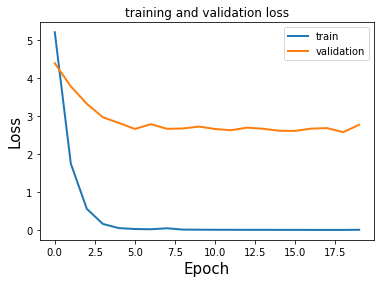

In [79]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

train_loss = np.load('../saved_models/task1/epoch20_0.0001/train_loss.npy')
val_loss = np.load('../saved_models/task1/epoch20_0.0001/val_loss.npy')
plt.plot(train_loss, linewidth=2, label='train')
plt.plot(val_loss, linewidth=2, label='validation')
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.legend()
plt.title('training and validation loss')

val accuracy: 0.44464287
train accuracy: 0.99960935


Text(0.5, 1.0, 'training and validation Accuracy')

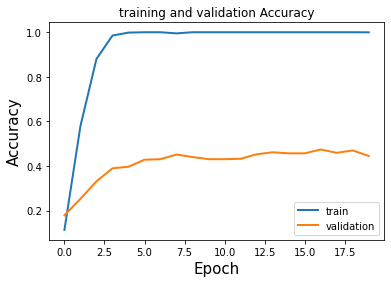

In [78]:
val_acc = np.load('../saved_models/task1/epoch20_0.0001/val_acc.npy')
train_acc = np.load('../saved_models/task1/epoch20_0.0001/train_acc.npy')
print('val accuracy:', val_acc[-1])
print('train accuracy:', train_acc[-1])
plt.plot(train_acc, linewidth=2, label='train')
plt.plot(val_acc, linewidth=2, label='validation')
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.legend()
plt.title('training and validation Accuracy')

labels shape (545,)
pred shape (545,)


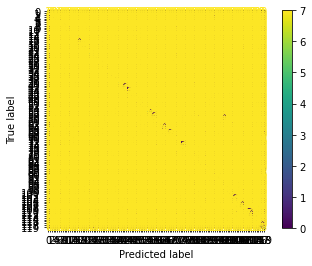

In [59]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, recall_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
test_labels = np.array(test_labels)
test_pred = np.array(test_pred)
print('labels shape', test_labels.shape)
print('pred shape', test_pred.shape)
cm = confusion_matrix(test_pred, test_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [75]:
def wrong_and_right(net, test_data_loader, device):
    net = net.to(device)
    test_steps = len(test_data_loader)
    t_acc=0
    wrong = 0 
    right = 0 
    for i, data in enumerate(test_data_loader): # iterate over batches
    # get image and labels data is in tuple form (inputs, label)
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        net.eval()
        torch.no_grad()   
        outputs = net(inputs)
        _, pred = torch.max(outputs, 1)        
        t_acc = torch.sum(pred == labels)
        if t_acc <16 and t_acc>0:
            for i in range(0,16):
                if pred[i] != labels[i] and wrong == 0:
                    print('prediction: ', pred[i])
                    print('label: ', labels[i])
                    wrong = 1
                    plt.imshow(inputs[i].permute(1, 2, 0))
                    plt.show()
                if pred[i] == labels[i] and right == 0:
                    print('prediction: ', pred[i])
                    print('label: ', labels[i])
                    right = 1
                    plt.imshow(inputs[i].permute(1, 2, 0))
                    plt.show()
                if wrong ==1 and right==1:
                    return 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


prediction:  tensor(84)
label:  tensor(22)


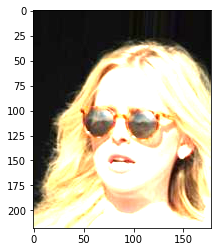

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


prediction:  tensor(107)
label:  tensor(107)


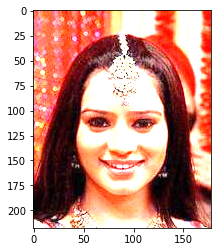

In [77]:
path = '../saved_models/task1/epoch20_0.0001/task1.pt'
net = Net().to(device)
net.load_state_dict(torch.load(path))
a = wrong_and_right(net,test_data_loader, device)